# Module 2 Final Project Specifications

## Introduction

In this lesson, we'll review all the guidelines and specifications for the final project for Module 2. 

## Objectives

* Understand all required aspects of the Final Project for Module 2
* Understand all required deliverables
* Understand what constitutes a successful project

### Final Project Summary

Another module down--you're half way there!

<img src='halfway-there.gif'>

For the culmination of Module 2, you just need to complete the final project!

### The Project

For this project, you'll be working with the Northwind database--a free, open-source dataset created by Microsoft containing data from a fictional company. You probably remember the Northwind database from our section on Advanced SQL. Here's the schema for the Northwind database:

<img src='Northwind_ERD.png'>

The goal of this project is to test your ability to gather information from a real-world database and use your knowledge of statistical analysis and hypothesis testing to generate analytical insights that can be of value to the company. 

## The Deliverables

The goal of your project is to query the database to get the data needed to perform a statistical analysis.  In this statistical analysis, you'll need to perform a hypothesis test (or perhaps several) to answer the following question:

**_Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?_**

In addition to answering this question with a hypothesis test, you will also need to come up with **_at least 3 other hypotheses to test on your own_**.  These can by anything that you think could be imporant information for the company. 

For this hypothesis, be sure to specify both the **_null hypothesis_** and the **_alternative hypothesis_** for your question.  You should also specify if this is one-tail or a two-tail test. 

To complete this project, you will need to turn in the following 3 deliverables:

1. A **_Jupyter Notebook_** containing any code you've written for this project. 
2. A **_Blog Post_** explaining your process, methodology, and findings.  
3. An **_"Executive Summary" PowerPoint Presentation_** that explains the hypothesis tests you ran, your findings, and their relevance to company stakeholders.  

### Jupyter Notebook Must-Haves

For this project, your jupyter notebook should meet the following specifications:

**_Organization/Code Cleanliness_**

* The notebook should be well organized, easy to follow, and code is commented where appropriate.  
<br>  
    * Level Up: The notebook contains well-formatted, professional looking markdown cells explaining any substantial code. All functions have docstrings that act as professional-quality documentation.  
<br>      
* The notebook is written to technical audiences with a way to both understand your approach and reproduce your results. The target audience for this deliverable is other data scientists looking to validate your findings.  
<br>    
* Any SQL code written to source data should also be included.  

**_Findings_**

* Your notebook should clearly show how you arrived at your results for each hypothesis test, including how you calculated your p-values.   
<br>
* You should also include any other statistics that you find relevant to your analysis, such as effect size. 

### Blog Post Must-Haves

Your blog post should include everything from how you identified what tables contained the information you need, to how you retrieved it using SQL (and any challenges you ran into while doing so), as well as your methodology and results for your hypothesis tests. 

**_NOTE:_**  This blog post is your way of showcasing the work you've done on this project--chances are it will soon be read by a recruiter or hiring manager! Take the time to make sure that you craft your story well, and clearly explain your process and findings in a way that clearly shows both your technical expertise **_and_** your ability to communicate your results!

### Executive Summary Must-Haves

Your presentation should:

* Contain between 5-10 professional quality slides detailing:
<br>  
    * A high-level overview of your methodology  
    <br>  
    * The results of your hypothesis tests  
    <br>  
    * Any real-world recommendations you would like to make based on your findings (ask yourself--why should the executive team care about what you found? How can your findings help the company?)  
    <br>  
* Take no more than 5 minutes to present  
<br>  
* Avoid technical jargon and explain results in a clear, actionable way for non-technical audiences.  

# Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?


In [185]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats 
import seaborn as sns
from scipy.stats import ttest_1samp
import statsmodels.api as sm
from statsmodels.formula.api import ols
conn = sqlite3.connect('Northwind_small.sqlite', detect_types = sqlite3.PARSE_COLNAMES)
c = conn.cursor()

# Early Data Exploration

In [186]:
select_all = "SELECT * FROM sqlite_master WHERE type='table'";
c.execute(select_all)
c.fetchall()

[('table',
  'Employee',
  'Employee',
  2,
  'CREATE TABLE "Employee" \n(\n  "Id" INTEGER PRIMARY KEY, \n  "LastName" VARCHAR(8000) NULL, \n  "FirstName" VARCHAR(8000) NULL, \n  "Title" VARCHAR(8000) NULL, \n  "TitleOfCourtesy" VARCHAR(8000) NULL, \n  "BirthDate" VARCHAR(8000) NULL, \n  "HireDate" VARCHAR(8000) NULL, \n  "Address" VARCHAR(8000) NULL, \n  "City" VARCHAR(8000) NULL, \n  "Region" VARCHAR(8000) NULL, \n  "PostalCode" VARCHAR(8000) NULL, \n  "Country" VARCHAR(8000) NULL, \n  "HomePhone" VARCHAR(8000) NULL, \n  "Extension" VARCHAR(8000) NULL, \n  "Photo" BLOB NULL, \n  "Notes" VARCHAR(8000) NULL, \n  "ReportsTo" INTEGER NULL, \n  "PhotoPath" VARCHAR(8000) NULL \n)'),
 ('table',
  'Category',
  'Category',
  3,
  'CREATE TABLE "Category" \n(\n  "Id" INTEGER PRIMARY KEY, \n  "CategoryName" VARCHAR(8000) NULL, \n  "Description" VARCHAR(8000) NULL \n)'),
 ('table',
  'Customer',
  'Customer',
  4,
  'CREATE TABLE "Customer" \n(\n  "Id" VARCHAR(8000) PRIMARY KEY, \n  "CompanyNam

In [187]:
select_all = "SELECT * FROM orderdetail";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


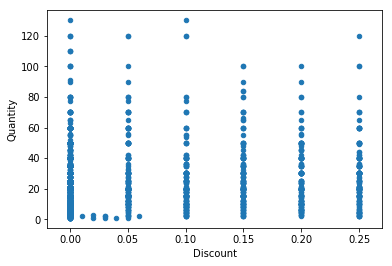

In [188]:
ax1=df.plot.scatter(x='Discount', y='Quantity')

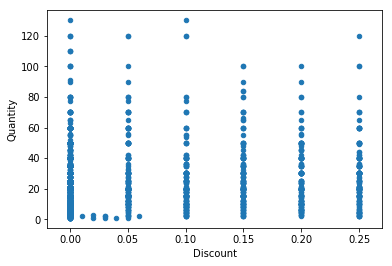

In [189]:
ax1=df.plot.scatter(x='Discount', y='Quantity')

Looks like the discount percentages are clustered around the .5 increments. Lets Take a look at how the averages change for each .5 increment. 

# Setting Our Control
Since we will be obeserving how discounting impacts the quantity or a product that gets ordered we ought to set the control to one where there is no discount

In [190]:
select_all = "SELECT * FROM orderdetail where discount = 0";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [191]:
df['Discount'].mean()

0.0

In [192]:
np.std(df['Quantity'])

17.500845477669806

In [193]:
mu = df['Quantity'].mean()
df['Quantity'].mean()

21.715261958997722

So it looks like the average quantity ordered when there is no discount on the product is 21.715. 

In [194]:
select_all = "SELECT * FROM orderdetail where discount > 0";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.4,35,0.15
1,10250/65,10250,65,16.8,15,0.15
2,10251/22,10251,22,16.8,6,0.05
3,10251/57,10251,57,15.6,15,0.05
4,10252/20,10252,20,64.8,40,0.05


In [195]:
df['Quantity'].mean()

27.10978520286396

# Null Hypothesis: Discount  does not increase Order Quantity 
H0: mu <= 21.715261

# Alternate Hypothesis: Discount increases order quantity
HA: x_bar > 21.715261

We will be running a one sided test. 

In [196]:
select_all = "SELECT * FROM orderdetail where discount = 0";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [197]:
print(len(df.index))

1317


In [198]:
df['Quantity'].mean()

21.715261958997722

In [199]:
np.std(df['Quantity'])

17.500845477669806

# Lets try to see how the value changes when we increase the discount to .05

In [200]:
select_all = "SELECT * FROM orderdetail where discount = .05";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10251/22,10251,22,16.8,6,0.05
1,10251/57,10251,57,15.6,15,0.05
2,10252/20,10252,20,64.8,40,0.05
3,10252/33,10252,33,2.0,25,0.05
4,10266/12,10266,12,30.4,12,0.05


In [201]:
n = len(df.index)
print(len(df.index))

185


In [202]:
x_bar = df['Quantity'].mean()
df['Quantity'].mean()

28.01081081081081

In [203]:
sigma = np.std(df['Quantity'])
np.std(df['Quantity'])

22.12763691763768

In [204]:
t = (x_bar-mu)/(sigma/np.sqrt(n))
t

3.8697635162291255

In [205]:
t_crit = stats.t.ppf(.95, n-1)
t_crit

1.6531770875301313

In [206]:
TSTAT, PVAL = ttest_1samp(df['Quantity'], mu)
PVAL

0.00015724773024925913

Our P value is miniscule, making this test significant. 

# We can observe a few things here: 
* The sample shrinks quite a bit from over 1000 observations to less than 150. 
* The Mean increases by almost 25%
* The Standard Deviation appears to be quite large.
* We can reject Null at a >99% C.I.

Lets go ahead and see what happens when we do this for the other rates. 

# Running the Test

In [207]:
select_all = "SELECT * FROM orderdetail where discount = .1 ";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10288/54,10288,54,5.9,10,0.1
1,10288/68,10288,68,10.0,3,0.1
2,10291/13,10291,13,4.8,20,0.1
3,10291/44,10291,44,15.5,24,0.1
4,10291/51,10291,51,42.4,2,0.1


In [208]:
n = len(df.index)
print(len(df.index))

173


In [209]:
x_bar = df['Quantity'].mean()
df['Quantity'].mean()

25.23699421965318

In [210]:
sigma = np.std(df['Quantity'])
np.std(df['Quantity'])

21.125181975751996

In [211]:
t = (x_bar-mu)/(sigma/np.sqrt(n))
t

2.19269854557591

In [212]:
t_crit = stats.t.ppf(.95, n-1)
t_crit

1.6537609493607581

In [213]:
TSTAT, PVAL = ttest_1samp(df['Quantity'], mu)
PVAL

0.030140467542048813

We see much the same thing Here. The P value is slightly higher but still allows us to reject at a 95% C.I. when the discount amount is .1

In [214]:
select_all = "SELECT * FROM orderdetail where discount = .15";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.4,35,0.15
1,10250/65,10250,65,16.8,15,0.15
2,10254/24,10254,24,3.6,15,0.15
3,10254/55,10254,55,19.2,21,0.15
4,10264/41,10264,41,7.7,25,0.15


In [215]:
df['Quantity'].mean()

28.38216560509554

In [216]:
np.std(df['Quantity'])

20.85635892029252

In [217]:
n = len(df.index)
print(len(df.index))

157


In [218]:
x_bar = df['Quantity'].mean()
df['Quantity'].mean()

28.38216560509554

In [219]:
sigma = np.std(df['Quantity'])
np.std(df['Quantity'])

20.85635892029252

In [220]:
t = (x_bar-mu)/(sigma/np.sqrt(n))
t

4.005304260951076

In [221]:
t_crit = stats.t.ppf(.95, n-1)
t_crit

1.6546799956696048

In [222]:
TSTAT, PVAL = ttest_1samp(df['Quantity'], mu)
PVAL

0.00010039539674400324

Once Again we can fairly emphatically reject the Null Hypothesis that discount amount has no impact on order quantity. 

In [223]:
select_all = "SELECT * FROM orderdetail where discount = .2";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10258/2,10258,2,15.2,50,0.2
1,10258/5,10258,5,17.0,65,0.2
2,10258/32,10258,32,25.6,6,0.2
3,10262/5,10262,5,17.0,12,0.2
4,10285/1,10285,1,14.4,45,0.2


In [224]:
df['Quantity'].mean()

27.024844720496894

In [225]:
np.std(df['Quantity'])

18.774222551927533

In [226]:
n = len(df.index)
print(len(df.index))

161


In [227]:
x_bar = df['Quantity'].mean()
df['Quantity'].mean()

27.024844720496894

In [228]:
sigma = np.std(df['Quantity'])
np.std(df['Quantity'])

18.774222551927533

In [229]:
t = (x_bar-mu)/(sigma/np.sqrt(n))
t

3.588486947482116

In [230]:
t_crit = stats.t.ppf(.95, n-1)
t_crit

1.6544329014554642

In [231]:
TSTAT, PVAL = ttest_1samp(df['Quantity'], mu)
PVAL

0.0004595441403474353

We can Reject the null once again. 

In [232]:
select_all = "SELECT * FROM orderdetail where discount = .25";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10260/41,10260,41,7.7,16,0.25
1,10260/62,10260,62,39.4,15,0.25
2,10260/70,10260,70,12.0,21,0.25
3,10263/16,10263,16,13.9,60,0.25
4,10263/30,10263,30,20.7,60,0.25


In [233]:
df['Quantity'].mean()

28.24025974025974

In [234]:
np.std(df['Quantity'])

20.055136724127415

In [235]:
n = len(df.index)
print(len(df.index))

154


In [236]:
x_bar = df['Quantity'].mean()
df['Quantity'].mean()

28.24025974025974

In [237]:
sigma = np.std(df['Quantity'])
np.std(df['Quantity'])

20.055136724127415

In [238]:
t = (x_bar-mu)/(sigma/np.sqrt(n))
t

4.037523858357001

In [239]:
t_crit = stats.t.ppf(.95, n-1)
t_crit

1.6548738467789963

In [240]:
TSTAT, PVAL = ttest_1samp(df['Quantity'], mu)
PVAL

8.956680896137234e-05

Once again, hih t value, miniscule P value. We can reject the null.  

In [241]:
select_all = "SELECT * FROM orderdetail where discount = 0";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [242]:
select_all = "SELECT * FROM orderdetail where discount = .05";
c.execute(select_all)
df1 = pd.DataFrame(c.fetchall())
df1.columns = [i[0] for i in c.description]
df1.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10251/22,10251,22,16.8,6,0.05
1,10251/57,10251,57,15.6,15,0.05
2,10252/20,10252,20,64.8,40,0.05
3,10252/33,10252,33,2.0,25,0.05
4,10266/12,10266,12,30.4,12,0.05


In [243]:
select_all = "SELECT * FROM orderdetail where discount = .1";
c.execute(select_all)
df2 = pd.DataFrame(c.fetchall())
df2.columns = [i[0] for i in c.description]
df2.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10288/54,10288,54,5.9,10,0.1
1,10288/68,10288,68,10.0,3,0.1
2,10291/13,10291,13,4.8,20,0.1
3,10291/44,10291,44,15.5,24,0.1
4,10291/51,10291,51,42.4,2,0.1


In [244]:
select_all = "SELECT * FROM orderdetail where discount = .15";
c.execute(select_all)
df3 = pd.DataFrame(c.fetchall())
df3.columns = [i[0] for i in c.description]
df3.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.4,35,0.15
1,10250/65,10250,65,16.8,15,0.15
2,10254/24,10254,24,3.6,15,0.15
3,10254/55,10254,55,19.2,21,0.15
4,10264/41,10264,41,7.7,25,0.15


In [245]:
select_all = "SELECT * FROM orderdetail where discount = .20";
c.execute(select_all)
df4 = pd.DataFrame(c.fetchall())
df4.columns = [i[0] for i in c.description]
df4.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10258/2,10258,2,15.2,50,0.2
1,10258/5,10258,5,17.0,65,0.2
2,10258/32,10258,32,25.6,6,0.2
3,10262/5,10262,5,17.0,12,0.2
4,10285/1,10285,1,14.4,45,0.2


In [246]:
select_all = "SELECT * FROM orderdetail where discount = .25";
c.execute(select_all)
df5 = pd.DataFrame(c.fetchall())
df5.columns = [i[0] for i in c.description]
df5.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10260/41,10260,41,7.7,16,0.25
1,10260/62,10260,62,39.4,15,0.25
2,10260/70,10260,70,12.0,21,0.25
3,10263/16,10263,16,13.9,60,0.25
4,10263/30,10263,30,20.7,60,0.25


# Does Price have a statistically significant effect on the quantity of a product in an order? If so, at what level(s)?

In [247]:
select_all = "SELECT * FROM orderdetail ";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


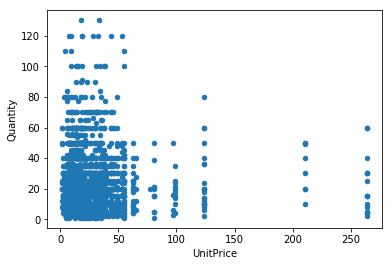

In [248]:
ax1=df.plot.scatter(x='UnitPrice', y='Quantity')

# H0: Unit Price has no impact on Quantity

# HA: Unit Price does have an impact on quantity. 

We will be checking first at the 95% C.I. and we will be running a two-sided test.

Lets Compare the mean unit price above the median and below the median to the mean to whether they affect price!

In [249]:
df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [250]:
df['UnitPrice'].mean()


26.218519721577728

In [251]:
mu=df['Quantity'].mean()
mu

23.812993039443157

In [252]:
select_all = "SELECT * FROM orderdetail where UnitPrice < 9.5";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/41,10250,41,7.7,10,0.00
1,10252/33,10252,33,2.0,25,0.05
2,10254/24,10254,24,3.6,15,0.15
3,10254/74,10254,74,8.0,21,0.00
4,10259/21,10259,21,8.0,10,0.00


In [253]:
x_bar=df['Quantity'].mean()
x_bar

22.395770392749245

In [254]:
df['Quantity'].mean()

22.395770392749245

In [255]:
np.std(df['Quantity'])

18.286504200826837

In [256]:
n = len(df.index)
print(len(df.index))

331


In [257]:
x_bar = df['Quantity'].mean()
df['Quantity'].mean()

22.395770392749245

In [258]:
sigma = np.std(df['Quantity'])
np.std(df['Quantity'])

18.286504200826837

In [259]:
t = (x_bar-mu)/(sigma/np.sqrt(n))
t

-1.4100073949781358

In [260]:
t_crit = stats.t.ppf(.975, n-1)
t_crit

1.9671786747531812

In [261]:
TSTAT, PVAL = ttest_1samp(df['Quantity'], mu)
PVAL

0.16010913578628178

It appears that we fail to reject the Null Hypothesis when we lower the price, let's try increasing it. We will be using the quantities from the products that are in the 75th percentile and higher for this one.  

In [262]:
select_all = "SELECT * FROM orderdetail where UnitPrice > 18.4";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/72,10248,72,34.8,5,0.00
1,10249/14,10249,14,18.6,9,0.00
2,10249/51,10249,51,42.4,40,0.00
3,10250/51,10250,51,42.4,35,0.15
4,10252/20,10252,20,64.8,40,0.05


In [263]:
df['Quantity'].mean()


23.87406015037594

In [264]:
df['Quantity'].mean()

23.87406015037594

In [265]:
np.std(df['Quantity'])

19.31737122083644

In [266]:
n = len(df.index)
print(len(df.index))

1064


In [267]:
x_bar = df['Quantity'].mean()
df['Quantity'].mean()

23.87406015037594

In [268]:
sigma = np.std(df['Quantity'])
np.std(df['Quantity'])

19.31737122083644

In [269]:
t = (x_bar-mu)/(sigma/np.sqrt(n))
t

0.10311697456678473

In [270]:
t_crit = stats.t.ppf(.975, n-1)
t_crit

1.962198160187531

In [271]:
TSTAT, PVAL = ttest_1samp(df['Quantity'], mu)
PVAL

0.917928040815583

Once again, it appears that we cannot reject the null hypothesis here. Therefore, we can't say Unit Price has an impact on Quantity

# Does Units in Stock have a statistically significant effect on Units on order? If so, at what level(s)?

Let's set discontinued to 0 so that discontinued products that have nothing in stock and no orders do not muddle the data

In [272]:
select_all = "SELECT * FROM product where discontinued = 0";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.0,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.0,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.0,53,0,0,0
4,6,Grandma's Boysenberry Spread,3,2,12 - 8 oz jars,25.0,120,0,25,0


# H0:  Units in stock has no impact on Units in order
* mu = X_bar


# HA: Units in stock has an impact on Units in order
* mu != X_bar

Two Sided test

In [273]:
df.describe()

,Id,SupplierId,CategoryId,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.0
mean,40.521739,13.913043,4.028986,26.734348,43.739130,11.304348,13.913043,0.0
std,22.585529,8.306162,2.419109,32.464316,36.591003,24.187566,10.636700,0.0
min,1.000000,1.000000,1.000000,2.500000,0.000000,0.000000,0.000000,0.0
25%,21.000000,7.000000,2.000000,13.000000,17.000000,0.000000,5.000000,0.0
50%,41.000000,14.000000,3.000000,19.000000,29.000000,0.000000,15.000000,0.0
75%,60.000000,21.000000,6.000000,31.230000,65.000000,0.000000,25.000000,0.0
max,77.000000,29.000000,8.000000,263.500000,125.000000,100.000000,30.000000,0.0


In [274]:
mu = df['UnitsOnOrder'].mean()
mu

11.304347826086957

In [275]:
median = np.median(df['UnitsInStock'])
median

29.0

In [276]:
select_all = "SELECT * FROM product where UnitsInStock <= 29 and discontinued = 0";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,2,Chang,1,1,24 - 12 oz bottles,19.0,17,40,25,0
1,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.0,13,70,25,0
2,7,Uncle Bob's Organic Dried Pears,3,7,12 - 1 lb pkgs.,30.0,15,0,10,0
3,8,Northwoods Cranberry Sauce,3,2,12 - 12 oz jars,40.0,6,0,0,0
4,11,Queso Cabrales,5,4,1 kg pkg.,21.0,22,30,30,0


In [277]:
df['UnitsOnOrder'].mean()


22.285714285714285

In [278]:
np.std(df['UnitsOnOrder'])

29.865002383173163

In [279]:
n = len(df.index)
print(len(df.index))

35


In [280]:
x_bar = np.mean(df['UnitsOnOrder'])
x_bar

22.285714285714285

In [281]:
sigma = np.std(df['UnitsOnOrder'])
np.std(df['UnitsOnOrder'])

29.865002383173163

In [282]:
t = (x_bar-mu)/(sigma/np.sqrt(n))
t

2.175343543224145

In [283]:
t_crit = stats.t.ppf(.975, n-1)
t_crit

2.032244509317718

In [284]:
TSTAT, PVAL = ttest_1samp(df['UnitsOnOrder'], mu)
PVAL

0.03926559570992175

# Answer: t>t_crit We can Reject our Null Hypothesis. 
Additionally, our P value is miniscule and we can see that for the portion below the median, the mean units on order practically doubles. 

In [285]:
X_bar = np.median(df['UnitsOnOrder'])
X_bar

0.0

In [286]:
select_all = "SELECT * FROM product where UnitsInStock > 29 and discontinued = 0";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0
1,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.0,53,0,0,0
2,6,Grandma's Boysenberry Spread,3,2,12 - 8 oz jars,25.0,120,0,25,0
3,10,Ikura,4,8,12 - 200 ml jars,31.0,31,0,0,0
4,12,Queso Manchego La Pastora,5,4,10 - 500 g pkgs.,38.0,86,0,0,0


In [287]:
df['UnitsOnOrder'].mean()


0.0

In [288]:
np.std(df['UnitsOnOrder'])

0.0

In [289]:
n = len(df.index)
print(len(df.index))

34


In [290]:
X_bar = np.mean(df['UnitsOnOrder'])
X_bar

0.0

In [291]:
sigma = np.std(df['UnitsOnOrder'])
np.std(df['UnitsOnOrder'])

0.0

In [292]:
t = (x_bar-mu)/(sigma/np.sqrt(n))
t

C:\Users\xxtur\Anaconda3\envs\learn-env\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


inf

In [293]:
t_crit = stats.t.ppf(.975, n-1)
t_crit

2.0345152974493383

In [294]:
TSTAT, PVAL = ttest_1samp(df['UnitsOnOrder'], mu)
PVAL

0.0

It becomes legitimately impossible to calculate the t value since all the values in the set are 0. That obviously rejects the null hypothesis. Looking at it from a non stats heavy prespective, we can see that basically any product that has more than 29 of it has zero orders for it and all the orders are for products with fewer than 29 units, granting credence to the idea that only products with 

# Does Reorder Level Impact UnitsInOrder?
# H0: Reorder Level does not increase Units In Order 
# HA: Reorder Level increases Units in Order
We will be running a one sided test. 

In [295]:
select_all = "SELECT * FROM product where discontinued = 0";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.0,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.0,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.0,53,0,0,0
4,6,Grandma's Boysenberry Spread,3,2,12 - 8 oz jars,25.0,120,0,25,0


In [296]:
median = np.median(df['ReorderLevel'])
median

15.0

In [297]:
mu= np.mean(df['UnitsInStock'])
mu

43.73913043478261

In [298]:
select_all = "SELECT * FROM product where ReorderLevel < 15 and discontinued = 0";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0
1,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.0,53,0,0,0
2,7,Uncle Bob's Organic Dried Pears,3,7,12 - 1 lb pkgs.,30.0,15,0,10,0
3,8,Northwoods Cranberry Sauce,3,2,12 - 12 oz jars,40.0,6,0,0,0
4,10,Ikura,4,8,12 - 200 ml jars,31.0,31,0,0,0


In [299]:
df['UnitsOnOrder'].mean()


1.935483870967742

In [300]:
np.std(df['UnitsOnOrder'])

7.795513531351336

In [301]:
n = len(df.index)
print(len(df.index))

31


In [302]:
X_bar = np.mean(df['UnitsOnOrder'])
X_bar

1.935483870967742

In [303]:
sigma = np.std(df['UnitsOnOrder'])
sigma

7.795513531351336

In [304]:
t = (x_bar-mu)/(sigma/np.sqrt(n))
t

-15.322603881753345

In [305]:
t_crit = stats.t.ppf(.975, n-1)
t_crit

2.0422724563012373

In [306]:
TSTAT, PVAL = ttest_1samp(df['UnitsOnOrder'], mu)
PVAL

1.155963369210931e-23

We can reject the null hypothesis. 

# Lets Check to see if this fares the same way above the median

In [307]:
select_all = "SELECT * FROM product where ReorderLevel > 15 and discontinued = 0";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,2,Chang,1,1,24 - 12 oz bottles,19.0,17,40,25,0
1,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.0,13,70,25,0
2,6,Grandma's Boysenberry Spread,3,2,12 - 8 oz jars,25.0,120,0,25,0
3,11,Queso Cabrales,5,4,1 kg pkg.,21.0,22,30,30,0
4,22,Gustaf's Knäckebröd,9,5,24 - 500 g pkgs.,21.0,104,0,25,0


In [308]:
df['UnitsOnOrder'].mean()


20.714285714285715

In [309]:
np.std(df['UnitsOnOrder'])

30.464097303051602

In [310]:
n = len(df.index)
print(len(df.index))

28


In [311]:
X_bar = np.mean(df['UnitsInStock'])
X_bar

54.785714285714285

In [312]:
sigma = np.std(df['UnitsOnOrder'])
sigma

30.464097303051602

In [313]:
t = (x_bar-mu)/(sigma/np.sqrt(n))
t

-3.7263801607885534

In [314]:
t_crit = stats.t.ppf(.975, n-1)
t_crit

2.0518305164802833

In [315]:
TSTAT, PVAL = ttest_1samp(df['UnitsOnOrder'], mu)
PVAL

0.0005363065140411494

With a P val this low, we can reject the Null hypothesis. 

In [316]:
select_all = "SELECT * FROM product";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [317]:
X = df.drop(['Id', 'ProductName', 'QuantityPerUnit', 'UnitsOnOrder', 'SupplierId', 'UnitPrice', 'CategoryId'], axis=1)

In [318]:
X_int = sm.add_constant(X)
y = df['UnitsOnOrder']
model = sm.OLS(y,X_int.astype(float)).fit()

In [319]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           UnitsOnOrder   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     13.64
Date:                Wed, 05 Dec 2018   Prob (F-statistic):           3.73e-07
Time:                        13:35:16   Log-Likelihood:                -333.53
No. Observations:                  77   AIC:                             675.1
Df Residuals:                      73   BIC:                             684.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           12.4947      4.417      2.829      0.006       3.692      21.298
UnitsInStock    -0.3199      0.063     -5.090      0.000      -0.445      -0.195
ReorderLevel     0.9202      0.218      4.225      0.000       0.486       1.354
Discontinued    -8.4556      7.819     -1.081      0.283     -24.038       7.127
==============================================================================
Omnibus:                       25.839   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.984
Skew:                           1.364   Prob(JB):                     2.08e-09
Kurtosis:                       5.241   Cond. No.                         211.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Even with just two variables, we can predict 30 percent of the total variation within the dataset. 

In [333]:
select_all = "SELECT QuantityPerUnit, UnitsOnOrder FROM product";
c.execute(select_all)
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,QuantityPerUnit,UnitsOnOrder
0,10 boxes x 20 bags,0
1,24 - 12 oz bottles,40
2,12 - 550 ml bottles,70
3,48 - 6 oz jars,0
4,36 boxes,0
